## This jupyter notebook is to test dataloader and model of the original TABS with data augmentation

In [1]:
import importlib
import glob
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

import BasicLoader as BasicLoader
import Models.TABS_Model as TABS_Model

# Test Data and Dataloader

### When I was building the dataloader

In [90]:
## **Don't run this anymore
# loop through fold_2 to get 

data_root_folder = '../data/TABSdataset/'
folder = 'dlbs'
imgs_dir = os.path.join(data_root_folder, folder, 'Fold_1')
img_dirs = sorted(glob.glob(os.path.join(imgs_dir, '*.gz')))
imgs_dir = os.path.join(data_root_folder, folder, 'Fold_2')
img_dirs.extend(sorted(glob.glob(os.path.join(imgs_dir, '*.gz'))))
imgs_dir = os.path.join(data_root_folder, folder, 'Fold_3')
img_dirs.extend(sorted(glob.glob(os.path.join(imgs_dir, '*.gz'))))
print(len(img_dirs))

img_dirs_dic = [(img[img.index('00'):img.index('_session')], [img]) for img in img_dirs]
# print(img_dirs_dic[0:3])
img_dirs_dic = {k: v for k, v in img_dirs_dic}
img_dirs_ids = set(img_dirs_dic.keys())

imgs_dir_fsl = os.path.join(data_root_folder, folder, 'Masks_dlbs')
img_dirs_fsl = sorted(glob.glob(os.path.join(imgs_dir_fsl, '*.gz')))
for imgdir in img_dirs_fsl:
    imgdir_id = imgdir[imgdir.index('00'):imgdir.index('_pve')]
    if (imgdir_id in img_dirs_ids):
        img_dirs_dic[imgdir_id].append(imgdir)

for imgid in img_dirs_dic:
    assert len(img_dirs_dic[imgid]) == 4, 'There are some missing images or masks in {0}'.format(folder)

# img_file0 = imgs_files[42]
# print(img_file0)
# print(img_file0.index('00'))
# img_file0 = img_file0[img_file0.index('00'):img_file0.index('_session')]
# print(img_file0)

# file_list = ['0028640']
# file_set = {'0028640'}
# file_pattern = "*.txt"
# file_path = "/path/to/files/"

# imgs_dir = os.path.join(data_root_folder, folder, 'Masks_dlbs')
# matching_files = [file for file in glob.glob(os.path.join(imgs_dir, '*.gz')) if any(name in file for name in file_list)]
# matching_files = [file for file in glob.glob(os.path.join(imgs_dir, '*.gz'))]

# print(matching_files)
# print(len(matching_files))


129


### Understand what images look like

(182, 218, 182)
(182, 218, 182)
(182, 218, 182)
(182, 218, 182)
True
(182, 218)


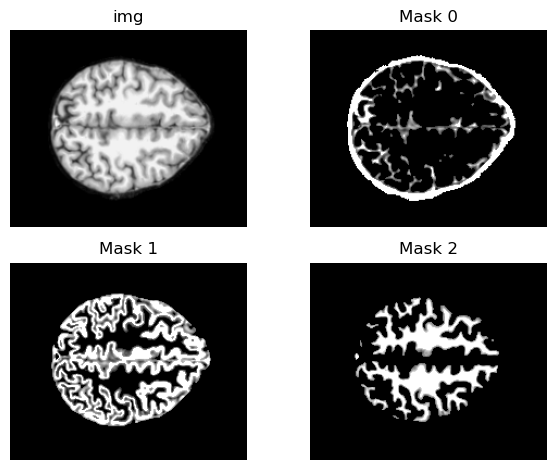

img [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   4.   2.  13.  45.  51.  55.  75.
  91.  97.  97.  83.  66.  61.  77.  90. 103. 108. 102.  96.  96. 100.
 104. 104. 104. 104. 106. 108. 110. 110. 110. 110. 110. 110. 109. 106.
 107. 108.  99.  87.  79.  81.  88.  98. 107. 106. 100.  91.  81.  76.
  66.  56.  47.  47.  63.  78.  85.  87.  91.  97. 102. 103. 103. 104.
 104. 106. 110. 111. 111. 110. 109. 106.  98.  89.  82.  82.  89.  97.
 105. 109. 108. 104. 101.  93.  82.  76.  78.  85.  96. 107. 109. 109.
 109. 109. 106.  90.  80.  72.  65.  65.  71.  75.  78.  86.  99. 109.
 109. 107.  98.  93.  90.  93.  99. 104. 105. 107. 109. 110. 110. 108.
 103.  93.  81.  77.  80.  86.  88.  98. 104. 105. 107. 106. 105. 106.
 104. 101.  99.  94.  83.  74.  64.  38.  25.  31.  34.  29.  20.  12.
   8.   4.   2.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  

In [4]:
test_load_img = nib.load('../../../data/TABSdataset/dlbs/Fold_1/dlbs_0028640_session_1_anat_1_anat_mri_brainmask_mni152brain_affine_tl.nii.gz').get_fdata()
test_load_0 = nib.load('../../../data/TABSdataset/dlbs/Masks_dlbs/dlbs_fsl_mask_0028640_pve_0.nii.gz').get_fdata()
test_load_1 = nib.load('../../../data/TABSdataset/dlbs/Masks_dlbs/dlbs_fsl_mask_0028640_pve_1.nii.gz').get_fdata()
test_load_2 = nib.load('../../../data/TABSdataset/dlbs/Masks_dlbs/dlbs_fsl_mask_0028640_pve_2.nii.gz').get_fdata()
print(test_load_img.shape)
print(test_load_0.shape)
print(test_load_1.shape)
print(test_load_2.shape)
print(isinstance(test_load_img, np.ndarray))
img = test_load_img[:,:,120]
mask0 = test_load_0[:,:,120]
mask1 = test_load_1[:,:,120]
mask2 = test_load_2[:,:,120]
print(img.shape)

plt.subplot(2,2,1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('img')

plt.subplot(2,2,2)
plt.imshow(mask0, cmap='gray')
plt.axis('off')
plt.title('Mask 0')

plt.subplot(2,2,3)
plt.imshow(mask1, cmap='gray')
plt.axis('off')
plt.title('Mask 1')

plt.subplot(2,2,4)
plt.imshow(mask2, cmap='gray')
plt.axis('off')
plt.title('Mask 2')

plt.tight_layout()
plt.show()

# print the array
print('img', img[100,:])
print('mask0', mask0[100,:])
print('mask1', mask1[100,:])
print('mask2', mask2[100,:])

### Test how to append and reshape

In [1]:
## **Don't run this anymore
test2 = test
a = np.zeros((10, 192, 182))
test3 = np.append(test2, a, axis=0)
print(test3.shape)
test = test3[:,:,60]
print(test.shape)
plt.imshow(test, cmap='gray')
plt.show()

NameError: name 'test' is not defined

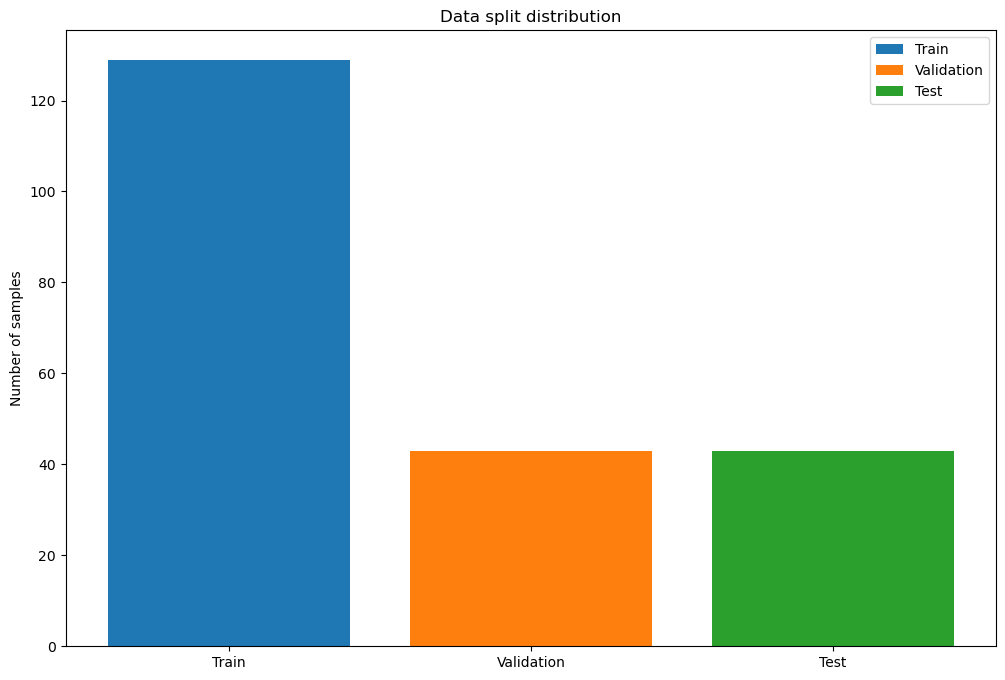

In [5]:
# Create train, validation, and test dataset instances
importlib.reload(BasicLoader)
train_dataset = BasicLoader.BasicDataset('dlbs', 'train')
valid_dataset = BasicLoader.BasicDataset('dlbs', 'valid')
test_dataset = BasicLoader.BasicDataset('dlbs', 'test')

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, num_workers=2, pin_memory=True)

plt.figure(figsize=(12,8))
plt.title('Data split distribution')
plt.bar(0, len(train_dataset), label='Train')
plt.bar(1, len(valid_dataset), label='Validation')
plt.bar(2, len(test_dataset), label='Test')
plt.ylabel('Number of samples')
plt.xticks([0,1,2],['Train', 'Validation', 'Test'])
plt.legend()
plt.show()

Sample num: 90
x shape is torch.Size([1, 192, 192, 192])
y shape is torch.Size([3, 192, 192, 192])


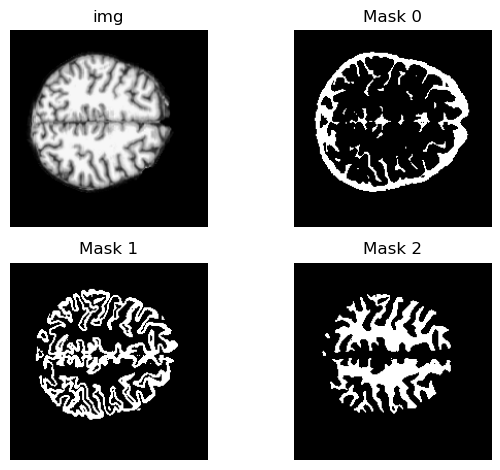

In [6]:
sample = np.random.randint(0, len(train_dataset))
print('Sample num:', sample)
data = train_dataset.__getitem__(sample)
x = data['image']
y = data['mask']
#idx = data['img_id']

print(f'x shape is {x.shape}')
print(f'y shape is {y.shape}')

plt.subplot(2,2,1)
plt.imshow(x[0,:,:,120], cmap='gray')
plt.axis('off')
plt.title('img')

plt.subplot(2,2,2)
plt.imshow(y[0,:,:,120], cmap='gray')
plt.axis('off')
plt.title('Mask 0')

plt.subplot(2,2,3)
plt.imshow(y[1,:,:,120], cmap='gray')
plt.axis('off')
plt.title('Mask 1')

plt.subplot(2,2,4)
plt.imshow(y[2,:,:,120], cmap='gray')
plt.axis('off')
plt.title('Mask 2')

plt.tight_layout()
plt.show()

## Test Model

dict_keys(['epoch', 'state_dict', 'optim_dict'])
179
0
Batch size: 2
Batch image shape: torch.Size([2, 1, 192, 192, 192])


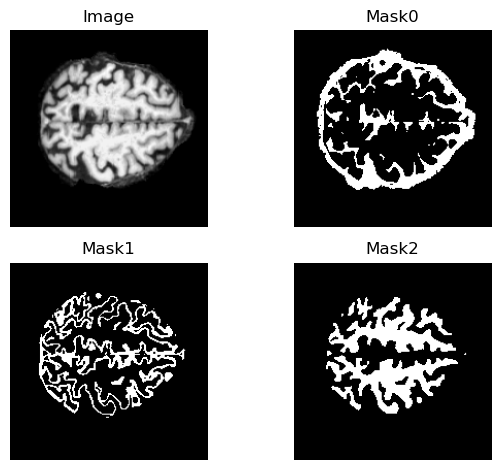

Output shape: torch.Size([2, 3, 192, 192, 192])


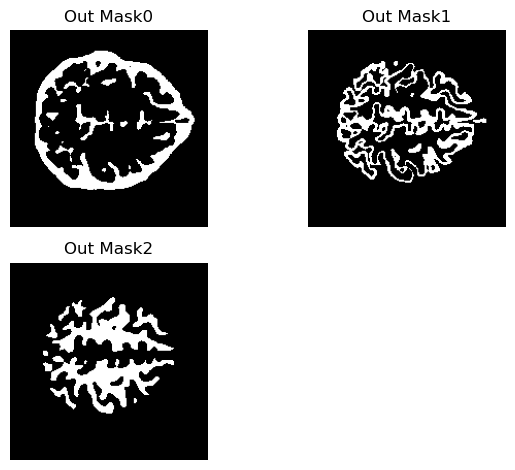

Output shape: torch.Size([2, 3, 192, 192, 192])


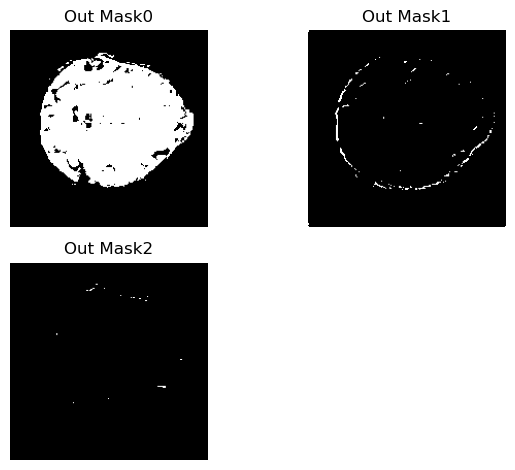

In [7]:
importlib.reload(TABS_Model)

torch.manual_seed(1000)
torch.cuda.manual_seed(1000)
random.seed(1000)
np.random.seed(1000)

tabs = TABS_Model.TABS()
tabs_pre_trained = TABS_Model.TABS()

load_model = './Results/Run_3/TABS_model_epoch_179_val_loss_0.10390213280916213.pth'
checkpoint = torch.load(load_model)
print(checkpoint.keys())
print(checkpoint['epoch'])
tabs.load_state_dict(checkpoint['state_dict'])
tabs.cuda()
tabs_pre_trained.cuda()

with torch.no_grad():
    for i, batch in enumerate(train_dataloader):
        print(i)
        
        imgs = batch['image'].cuda()
        masks = batch['mask'].cuda()
        
        # Show the batch picture
        print('Batch size:', len(imgs))
        print('Batch image shape:', imgs.shape)
        
        slice_num = 120
        img = imgs[0][0].cpu()
        img_slice = img[:,:,slice_num].cpu()
        mask0 = masks[0][0]
        mask0_slice = mask0[:,:,slice_num].cpu()
        mask1 = masks[0][1]
        mask1_slice = mask1[:,:,slice_num].cpu()
        mask2 = masks[0][2]
        mask2_slice = mask2[:,:,slice_num].cpu()
        
        plt.subplot(2, 2, 1)
        plt.title('Image')
        plt.imshow(img_slice, cmap='gray')
        plt.axis('off')
        plt.subplot(2, 2, 2)
        plt.title('Mask0')
        plt.imshow(mask0_slice, cmap='gray')
        plt.axis('off')
        plt.subplot(2, 2, 3)
        plt.title('Mask1')
        plt.imshow(mask1_slice, cmap='gray')
        plt.axis('off')
        plt.subplot(2, 2, 4)
        plt.title('Mask2')
        plt.imshow(mask2_slice, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        out = tabs(imgs)
        print('Output shape:', out.shape)
        
        out_mask0 = out[0][0]
        out_mask0_slice = out_mask0[:,:,slice_num].cpu().numpy()
        out_mask1 = out[0][1]
        out_mask1_slice = out_mask1[:,:,slice_num].cpu().numpy()
        out_mask2 = out[0][2]
        out_mask2_slice = out_mask2[:,:,slice_num].cpu().numpy()
        
        out_mask0_slice[out_mask0_slice <= 0.5] = 0.0
        out_mask0_slice[out_mask0_slice > 0.5] = 1.0
        out_mask1_slice[out_mask1_slice <= 0.5] = 0.0
        out_mask1_slice[out_mask1_slice > 0.5] = 1.0
        out_mask2_slice[out_mask2_slice <= 0.5] = 0.0
        out_mask2_slice[out_mask2_slice > 0.5] = 1.0
        
        plt.subplot(2, 2, 1)
        plt.title('Out Mask0')
        plt.imshow(out_mask0_slice, cmap='gray')
        plt.axis('off')
        plt.subplot(2, 2, 2)
        plt.title('Out Mask1')
        plt.imshow(out_mask1_slice, cmap='gray')
        plt.axis('off')
        plt.subplot(2, 2, 3)
        plt.title('Out Mask2')
        plt.imshow(out_mask2_slice, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
#         print(out_mask0_slice[120,:])
        
        out_pre = tabs_pre_trained(imgs)
        print('Output shape:', out_pre.shape)
        
        out_mask0 = out_pre[0][0]
        out_mask0_slice = out_mask0[:,:,slice_num].cpu().numpy()
        out_mask1 = out_pre[0][1]
        out_mask1_slice = out_mask1[:,:,slice_num].cpu().numpy()
        out_mask2 = out_pre[0][2]
        out_mask2_slice = out_mask2[:,:,slice_num].cpu().numpy()
        
        out_mask0_slice[out_mask0_slice <= 0.5] = 0.0
        out_mask0_slice[out_mask0_slice > 0.5] = 1.0
        out_mask1_slice[out_mask1_slice <= 0.5] = 0.0
        out_mask1_slice[out_mask1_slice > 0.5] = 1.0
        out_mask2_slice[out_mask2_slice <= 0.5] = 0.0
        out_mask2_slice[out_mask2_slice > 0.5] = 1.0
        
        plt.subplot(2, 2, 1)
        plt.title('Out Mask0')
        plt.imshow(out_mask0_slice, cmap='gray')
        plt.axis('off')
        plt.subplot(2, 2, 2)
        plt.title('Out Mask1')
        plt.imshow(out_mask1_slice, cmap='gray')
        plt.axis('off')
        plt.subplot(2, 2, 3)
        plt.title('Out Mask2')
        plt.imshow(out_mask2_slice, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        break
        # print(len(batch))
        # print(len(batch['image']))
        # Load a batch and pass it to the GPU
        # imgs = batch['image'].cuda()
        # true_masks = batch['mask'].cuda()